In [85]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import re

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["figure.dpi"] = 73
plt.rc('font', size=20)

from common_plotting import add_thp, find_file
from common_analysis import combine_stds_mean
from common_analysis_dcv import relative_dcv_add_polarity
from common_analysis_resistance import analyse_ohms, PT385_eq, Trh

In [61]:
Trh_s = lambda Rt: (Rt - ((1+0.01e-2)*10e3)) / (0.1e-2*10e3) + 23

def analyse_dcv(data, meter, switch_group_start=5):
    data_with_groups = add_dcv_group(data)
    data_grouped = aggregate_dcv_data_by_group(data_with_groups, meter)
    temp = data_grouped.iloc[switch_group_start].copy()
    data_grouped.iloc[switch_group_start] = data_grouped.iloc[switch_group_start + 2].copy()
    data_grouped.iloc[switch_group_start + 2] = data_grouped.iloc[switch_group_start + 1].copy()
    data_grouped.iloc[switch_group_start + 1] = temp
    grouped_by_dut_group = aggregate_dcv_data_by_dut_group(data_grouped, meter)
    return grouped_by_dut_group

def analyse_dcmv(relative_data, reference_name, meter):
    relative_dcv_add_polarity(relative_data, reference_name, meter)
    relative_results = group_relative_results(relative_data, reference_name)
    return relative_results

def analyse_acv(data, meter):
    data_grouped = data.groupby('dut').agg({'dut': 'last', 'dut_setting': 'last', f'{meter}_acv': ['mean', 'std', 'sem', 'count'], 'temperature': 'mean'})
    data_grouped.columns = ['dut', 'dut_setting', 'acv_mean', 'acv_std', 'acv_sem', 'count', 'temperature_mean']
    return data_grouped


def add_temps(data):
    data['temp_pt100'] = data['f189_pt100_ohm'].apply(lambda resistance: fsolve(PT385_eq, 25, args=(resistance,))[0])
    if 'ag34401a_branadic_thermistor_ohm' in data.columns:
        data.loc[data.dut == 'SR104', 'temp_sr104_thermistor'] = data['ag34401a_branadic_thermistor_ohm'].apply(Trh)
        data.loc[data.dut == 'SR104-Sönke', 'temp_sr104_thermistor'] = data['ag34401a_branadic_thermistor_ohm'].apply(Trh_s)
    return data


def add_ac_cal_value_and_uncertainty(data, cal_data, specs, function, column_name, freq, time='90d'):
    data = add_3458a_ac_abs_uncertainty(add_ac_cal_value(data, cal_data, function, freq), specs, function, freq, time)
    data['corrected_mean'] = data[f'{column_name}_mean'] * data.correction
    data['expanded_uncertainty'] = 2*np.sqrt(data[f'{column_name}_sem']**2 + (data.uncertainty/1.96)**2 + (1/3*(data.gain * data.corrected_mean + data.offset * data.range)**2))
    return data

def add_ac_cal_value(data, cal_data, function, freq):
    function_cal_data = cal_data[cal_data.function == function].groupby('range').agg({'correction': 'mean', 'uncertainty': combine_stds_mean}).reset_index()
    return data.merge(function_cal_data[['range', 'correction', 'uncertainty']], left_on=['range'], right_on=['range'], how='left')

def add_3458a_ac_abs_uncertainty(data, ag3458a_specs, function, freq, time='90d'):
    ag3458a_specs_for_time = ag3458a_specs[(ag3458a_specs.time == time) & (ag3458a_specs.function == function) & (ag3458a_specs.freq_start <= freq) & (ag3458a_specs.freq_end >= freq)]
    return data.merge(ag3458a_specs_for_time, left_on='range', right_on='range', how='left')


def add_dc_cal_value_and_uncertainty(data, cal_data, specs, function, column_name, opt2=None, time='90d', relative=False):
    data = add_3458a_dc_abs_uncertainty(add_dc_cal_value(data, cal_data, function), specs, function, opt2, time)
    data['corrected_mean'] = data[f'{column_name}_mean'] * data.correction
    data['expanded_uncertainty'] = 2*np.sqrt(data[f'{column_name}_sem']**2 + ((data.uncertainty/1.96)**2 if not relative else 0) + (1/3*(data.gain * data.corrected_mean + data.offset * data.range)**2))
    return data

def add_dc_cal_value(data, cal_data, function):
    function_cal_data = cal_data[cal_data.function == function]
    return data.merge(function_cal_data[['range', 'input', 'correction', 'uncertainty']], left_on=['range', 'range'], right_on=['range', 'input'], how='left')

def add_3458a_dc_abs_uncertainty(data, ag3458a_specs, function, opt2=None, time='90d'):
    condition = (ag3458a_specs.time == time) & (ag3458a_specs.function == function)
    if opt2 is not None:
        condition &= (ag3458a_specs.opt2 == opt2)
    ag3458a_specs_for_time = ag3458a_specs[condition]
    return data.merge(ag3458a_specs_for_time, left_on='range', right_on='range')

def add_dcmv_uncertainty(data, specs, afilter=False, time='2y'):
    data = add_k2182_dcmv_uncertainty(data, specs, afilter, time)
    data['expanded_uncertainty'] = 2*np.sqrt(data['sem']**2 + (1/3*(data.gain * data[f'mean'] + data.offset * data.range)**2))
    return data

def add_k2182_dcmv_uncertainty(data, k2182_specs, afilter=False, time='2y'):
    condition = (k2182_specs.time == time) & (k2182_specs.afilter == afilter)
    k2182_specs_for_time = k2182_specs[condition]
    return data.merge(k2182_specs_for_time, left_on='range', right_on='range')

def add_dcv_group(data):
    data_groups = (data[['dut', 'dut_setting', 'comments']].apply(tuple, axis=1) != data[['dut', 'dut_setting', 'comments']].shift().apply(tuple, axis=1)).cumsum().rename('group')
    return data.join(data_groups)

def aggregate_dcv_data_by_group(data, meter):
    return data.groupby('group').agg({'dut': 'last', 'dut_setting': 'last', 'comments': 'last', f'{meter}_dcv': ['mean', 'std', 'sem', 'count'], 'temperature': ['mean', 'std', 'sem', 'count']})

def group_relative_results(relative_data, reference_name):
    grouped_by_dut_polarity = relative_data.groupby(['dut', 'polarity']).agg({'corrected_value': ['mean', 'std', 'sem', 'count'], 'temperature': 'mean'}).droplevel(0, axis=1).reset_index()
    grouped_by_dut_polarity.columns = ['dut', 'polarity', 'mean', 'std', 'sem', 'count', 'temperature']
    relative_results = grouped_by_dut_polarity.groupby('dut').agg({'mean': 'mean', 'sem': combine_stds_mean, 'count': 'sum', 'temperature': 'mean'})
    return relative_results

def relative_results_to_ppm(relative_results, reference_value):
    relative_results['mean_in_ppm'] = (relative_results['mean'] / reference_value) * 1e6
    relative_results['sem_in_ppm'] = (relative_results['sem'] / reference_value) * 1e6
    relative_results['expanded_uncertainty_in_ppm'] = (relative_results['expanded_uncertainty'] / reference_value) * 1e6
    return relative_results
    

def aggregate_dcv_data_by_group(data, meter):
    return data.groupby('group').agg({'dut': 'last', 'dut_setting': 'last', 'comments': 'last', f'{meter}_dcv': ['mean', 'std', 'sem', 'count'], 'temperature': ['mean', 'std', 'sem', 'count']})

def aggregate_dcv_data_by_dut_group(absolute_dcv_data, meter):
    data_with_dut_group = absolute_dcv_data.copy()
    data_with_dut_group['dut_group'] = (data_with_dut_group[['dut', 'comments']].apply(tuple, axis=1) != data_with_dut_group[['dut', 'comments']].shift(1).apply(tuple, axis=1)).cumsum()
    data_with_dut_group.columns = ['_'.join(col) for col in data_with_dut_group.columns.values]
    data_grouped_by_dut = data_with_dut_group.groupby('dut_group_').agg({'dut_last': 'last', 'comments_last': 'last', f'{meter}_dcv_mean': lambda v: np.mean(np.abs(v)), f'{meter}_dcv_sem': combine_stds_mean, 'temperature_mean': 'mean', 'ag3458a_branadic_dcv_count': 'sum'})
    data_grouped_by_dut.columns = ['dut', 'guard', 'dcv_mean', 'dcv_sem', 'temperature_mean', 'count']
    return data_grouped_by_dut

In [62]:
ut330c_data = pd.read_csv(find_file('UNT330C_20220909_141657.log.csv'), parse_dates=['DateTime'], encoding='latin_1')
ut330c_data['datetime_corrected'] = ut330c_data['DateTime'] - pd.Timedelta('1h')
ut330c = ut330c_data.drop(['  NO.', '°F', 'DateTime'], axis=1).set_index('datetime_corrected').dropna()
ut330c.columns= ['temperature', 'humidity', 'pressure', 'dew_point']

In [63]:
res_2w_data = add_thp(ut330c, pd.read_csv(find_file('mm2022-ag3458a_branadic-2w-res.csv'), parse_dates=['datetime']))
res_4w_data = add_thp(ut330c, pd.read_csv(find_file('mm2022-ag3458a_branadic-4w-res.csv'), parse_dates=['datetime']))
acv_data = add_thp(ut330c, pd.read_csv(find_file('mm2022-ag3458a_branadic-acv-log.csv'), parse_dates=['datetime']))
dcv_data = add_thp(ut330c, pd.read_csv(find_file('mm2022-ag3458a_branadic-dcv-log.csv'), parse_dates=['datetime']))
dcmv_data = add_thp(ut330c, pd.read_csv(find_file('mm2022-k2182a_branadic-dcmv-log.csv'), parse_dates=['datetime']))
ag3458a_dc_cal_data = pd.read_csv('./mm2022/branadic-3458a-dc-cal.txt')
ag3458a_ac_cal_data = pd.read_csv('./mm2022/branadic-3458a-ac-cal.txt')
ag3458a_specs = pd.read_csv(find_file('ag3458a-specs.csv'))
k2182_specs = pd.read_csv(find_file('k2182-specs.csv'))

In [64]:
ag3458a_dc_cal_data['expected'] = (ag3458a_dc_cal_data.min_limit + ag3458a_dc_cal_data.max_limit) / 2
ag3458a_dc_cal_data['correction'] = ag3458a_dc_cal_data.expected / ag3458a_dc_cal_data.measured
ag3458a_dc_cal_data_fixed_units = ag3458a_dc_cal_data[['function', 'range', 'range_unit', 'input', 'correction', 'uncertainty']].copy()
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'mV', 'uncertainty'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'mV']['uncertainty'] / 1e3
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'mV', 'range'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'mV']['range'] / 1e3
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'mV', 'input'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'mV']['input'] / 1e3
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'kΩ', 'uncertainty'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'kΩ']['uncertainty'] * 1e3
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'kΩ', 'range'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'kΩ']['range'] * 1e3
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'kΩ', 'input'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'kΩ']['input'] * 1e3
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'MΩ', 'uncertainty'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'MΩ']['uncertainty'] * 1e6
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'MΩ', 'range'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'MΩ']['range'] * 1e6
ag3458a_dc_cal_data_fixed_units.loc[ag3458a_dc_cal_data_fixed_units.range_unit == 'MΩ', 'input'] = ag3458a_dc_cal_data_fixed_units[ag3458a_dc_cal_data_fixed_units.range_unit == 'MΩ']['input'] * 1e6
ag3458a_dc_cal_data_fixed_units = ag3458a_dc_cal_data_fixed_units.drop(['range_unit'], axis=1)
ag3458a_dc_cal_data_fixed_units = pd.concat([ag3458a_dc_cal_data_fixed_units, ag3458a_dc_cal_data_fixed_units[(ag3458a_dc_cal_data_fixed_units.function == 'res4') & (ag3458a_dc_cal_data_fixed_units.range == 1000000)]])
ag3458a_dc_cal_data_fixed_units.iloc[-1,0] = 'res2'
ag3458a_dc_cal_data_fixed_units = ag3458a_dc_cal_data_fixed_units.reset_index().drop(['index'], axis=1)
ag3458a_ac_cal_data['expected'] = (ag3458a_ac_cal_data.min_limit + ag3458a_ac_cal_data.max_limit) / 2
ag3458a_ac_cal_data['correction'] = ag3458a_ac_cal_data.expected / ag3458a_ac_cal_data.measured
ag3458a_ac_cal_data_fixed_units = ag3458a_ac_cal_data[['function', 'range', 'range_unit', 'frequency', 'frequency_unit', 'input', 'correction', 'uncertainty']].copy()
ag3458a_ac_cal_data_fixed_units.loc[ag3458a_ac_cal_data_fixed_units.frequency_unit == 'kHz', 'frequency'] = ag3458a_ac_cal_data_fixed_units[ag3458a_ac_cal_data_fixed_units.frequency_unit == 'kHz']['frequency'] * 1e3
ag3458a_ac_cal_data_fixed_units = ag3458a_ac_cal_data_fixed_units.drop(['range_unit', 'frequency_unit'], axis=1)

In [65]:
res_2w_results = analyse_ohms(add_temps(res_2w_data), meter='ag3458a_branadic', remove_first_and_last=False, temperature_columns=['temperature', 'temp_pt100'])
res_4w_results = analyse_ohms(add_temps(res_4w_data), meter='ag3458a_branadic', remove_first_and_last=False, temperature_columns=['temperature', 'temp_pt100', 'temp_sr104_thermistor'])

/home/alson/shared/projects/personal/electronics/t&m/automation/data-analysis/.venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [66]:
add_dc_cal_value_and_uncertainty(res_4w_results, ag3458a_dc_cal_data_fixed_units, ag3458a_specs, 'res4', 'ohm')[['dut', 'count', 'temperature_mean', 'temp_pt100_mean', 'temp_sr104_thermistor_mean', 'corrected_mean', 'expanded_uncertainty', 'ohm_sem']]

,dut,count,temperature_mean,temp_pt100_mean,temp_sr104_thermistor_mean,corrected_mean,expanded_uncertainty,ohm_sem
0,SR104,20,2.2650000e+01,2.4679978e+01,2.2435650e+01,9.9999303e+03,9.9928712e-02,1.9481435e-03
1,SR104-Sönke,1,2.2400000e+01,2.5000000e+01,2.2964000e+01,1.0000072e+04,NaN,NaN
2,SR104,5,2.2500000e+01,2.5000000e+01,2.2682000e+01,9.9999816e+03,9.9856394e-02,4.0000000e-04
3,Guildline 9330,5,2.2660000e+01,2.4993153e+01,NaN,1.0000446e+05,1.0348703e+00,1.5165751e-02
4,HP 11103A,12,2.2550000e+01,2.4605662e+01,NaN,1.0000124e+03,1.0092619e-02,6.5664821e-05
5,Fluke 742A,9,2.2533333e+01,2.5944744e+01,NaN,1.0000391e+01,2.3725186e-04,2.6057865e-06


In [67]:
add_dc_cal_value_and_uncertainty(res_2w_results, ag3458a_dc_cal_data_fixed_units, ag3458a_specs, 'res2', 'ohm')[['dut', 'count', 'temperature_mean', 'temp_pt100_mean', 'corrected_mean', 'expanded_uncertainty']]

,dut,count,temperature_mean,temp_pt100_mean,corrected_mean,expanded_uncertainty
0,Fluke 742A,10,2.2600000e+01,2.5274134e+01,1.0000199e+06,1.8132762e+01
1,Guildline 95206,51,2.2492157e+01,2.5279643e+01,9.9998666e+06,7.2856986e+02


## DCV standards

### Absolute measurements using Keysight 3458A

In [68]:
dcv_res = analyse_dcv(dcv_data[dcv_data.comments != 'with guard to lo'], 'ag3458a_branadic', switch_group_start=5)
dcv_res['range'] = 10.0
add_dc_cal_value_and_uncertainty(dcv_res, ag3458a_dc_cal_data_fixed_units, ag3458a_specs, 'dcv', 'dcv', True)[['dut', 'guard', 'count', 'temperature_mean', 'corrected_mean', 'expanded_uncertainty']]
add_dc_cal_value_and_uncertainty(dcv_res, ag3458a_dc_cal_data_fixed_units, ag3458a_specs, 'dcv', 'dcv', True)

,dut,guard,dcv_mean,dcv_sem,temperature_mean,count,range,input,correction,uncertainty,function,time,freq_start,freq_end,opt2,gain,offset,corrected_mean,expanded_uncertainty
0,Fluke 7001 on battery (alm),with guard to open,9.9999887e+00,3.5887789e-08,2.2600000e+01,50,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05,dcv,90d,NaN,NaN,True,2.6000000e-06,5.0000000e-08,9.9999347e+00,3.4214089e-05
1,Fluke 7000 on battery (#4),with guard to open,1.0000040e+01,8.8191711e-08,2.2500000e+01,3,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05,dcv,90d,NaN,NaN,True,2.6000000e-06,5.0000000e-08,9.9999861e+00,3.4214606e-05
2,Fluke 7000 on battery (#1),"no guard, to lo",1.0000013e+01,9.2736185e-08,2.2500000e+01,5,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05,dcv,90d,NaN,NaN,True,2.6000000e-06,5.0000000e-08,9.9999591e+00,3.4214582e-05
3,Fluke 7000 on mains power (#2),"no guard, to lo",1.0000041e+01,1.2961481e-07,2.2450000e+01,10,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05,dcv,90d,NaN,NaN,True,2.6000000e-06,5.0000000e-08,9.9999875e+00,3.4215137e-05
4,Fluke 7000 on mains power (#4),"no guard, to lo",1.0000041e+01,2.0174241e-07,2.2500000e+01,10,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05,dcv,90d,NaN,NaN,True,2.6000000e-06,5.0000000e-08,9.9999875e+00,3.4216534e-05
5,Fluke 7001 on battery (alm),"no guard, to lo",9.9999905e+00,3.1622777e-08,2.2400000e+01,10,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05,dcv,90d,NaN,NaN,True,2.6000000e-06,5.0000000e-08,9.9999365e+00,3.4214077e-05
6,Fluke 7001 on battery (alm),with guard to open,9.9999900e+00,5.0990195e-08,2.2400000e+01,5,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05,dcv,90d,NaN,NaN,True,2.6000000e-06,5.0000000e-08,9.9999360e+00,3.4214169e-05


### Relative measurements using Keysight 3458A

In [69]:
dcv_rel_res = analyse_dcv(dcv_data[(dcv_data.comments != 'with guard to lo') & (dcv_data.index > pd.Timestamp(2022,8,27,14,55))], 'ag3458a_branadic', switch_group_start=2)
dcv_rel_res['range'] = 10.0
dcv_rel = add_dc_cal_value_and_uncertainty(dcv_rel_res, ag3458a_dc_cal_data_fixed_units, ag3458a_specs, 'dcv', 'dcv', True, "10min", relative=True)
reference_value = dcv_rel.loc[(dcv_rel.dut == 'Fluke 7001 on battery (alm)') & (dcv_rel.guard == 'no guard, to lo'), 'corrected_mean'].values[0]
dcv_rel['mean_in_ppm'] = (dcv_rel.corrected_mean - reference_value) / reference_value * 1e6
dcv_rel['expanded_uncertainty_in_ppm'] = dcv_rel.expanded_uncertainty / reference_value * 1e6
dcv_rel[['dut', 'guard', 'count', 'temperature_mean', 'mean_in_ppm', 'expanded_uncertainty_in_ppm']]
# dcv_rel

,dut,guard,count,temperature_mean,mean_in_ppm,expanded_uncertainty_in_ppm
0,Fluke 7000 on battery (#1),"no guard, to lo",5,2.2500000e+01,2.2630021e+00,1.1695064e-01
1,Fluke 7000 on mains power (#2),"no guard, to lo",10,2.2450000e+01,5.0960048e+00,1.1834481e-01
2,Fluke 7000 on mains power (#4),"no guard, to lo",10,2.2500000e+01,5.0980048e+00,1.2231724e-01
3,Fluke 7001 on battery (alm),"no guard, to lo",10,2.2400000e+01,0.0000000e+00,1.1564350e-01
4,Fluke 7001 on battery (alm),with guard to open,5,2.2400000e+01,-4.7000045e-02,1.1591988e-01


### Relative measurements using Keithley 2182A

In [70]:
dcmv_res = analyse_dcmv(dcmv_data, 'Fluke 7001 on battery (alm)', 'k2182a')
dcmv_res = dcmv_res.reset_index()
dcmv_res['range'] = 10e-3
dcmv_res['mean'] -= dcmv_res.loc[dcmv_res.dut == 'short', 'mean'].values[0]
dcmv_res = dcmv_res[dcmv_res.dut != 'short']
dcmv_with_uncertainty = add_dcmv_uncertainty(dcmv_res, k2182_specs, True, '2y')
dcmv_results = relative_results_to_ppm(dcmv_with_uncertainty, 9.999935)[['dut', 'mean_in_ppm', 'expanded_uncertainty_in_ppm', 'count', 'temperature']]
dcmv_results

,dut,mean_in_ppm,expanded_uncertainty_in_ppm,count,temperature
0,Fluke 7000 on battery (#1),2.1271288e+00,8.9739691e-03,27,2.2500000e+01
1,Fluke 7000 on battery (#2),4.9863890e+00,1.2099297e-02,26,2.2500000e+01
2,Fluke 7000 on battery (#4),5.1075277e+00,1.1392367e-02,25,2.2540909e+01


values relative to 'Fluke 7001 on battery (alm)'

### Relative value comparison

,label,mean_in_ppm,expanded_uncertainty_in_ppm
0,1 - 3458A,2.2630021e+00,1.1695064e-01
1,1 - K2182A,2.1271288e+00,8.9739691e-03
2,2 - 3458A,5.0960048e+00,1.1834481e-01
3,2 - K2182A,4.9863890e+00,1.2099297e-02
4,4 - 3458A,5.0980048e+00,1.2231724e-01
5,4 - K2182A,5.1075277e+00,1.1392367e-02
6,alm - 3458A,0.0000000e+00,1.1564350e-01


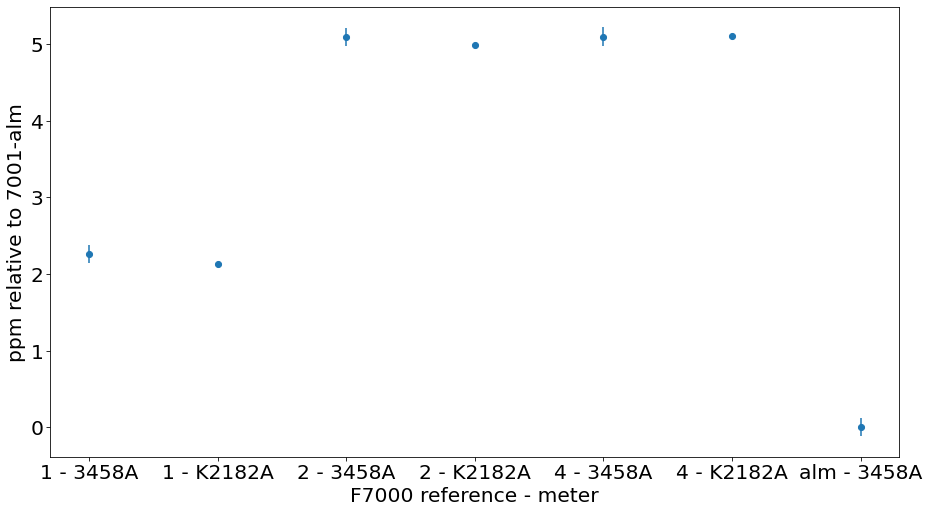

In [86]:
ag3458a_relative_data = dcv_rel[dcv_rel.guard == 'no guard, to lo'][['dut', 'mean_in_ppm', 'expanded_uncertainty_in_ppm']]
ag3458a_relative_data['meter'] = '3458A'
k2182_relative_data = dcmv_results[['dut', 'mean_in_ppm', 'expanded_uncertainty_in_ppm']].copy()
k2182_relative_data['meter'] = 'K2182A'
combined_relative_data = pd.concat([ag3458a_relative_data, k2182_relative_data], axis=0)
combined_relative_data['label'] = combined_relative_data.dut.apply(lambda dut: re.sub(r'^[^(]+\(#?([^#)]+)\)$', r'\1', dut)) + ' - ' + combined_relative_data.meter
combined_relative_data = combined_relative_data[['label', 'mean_in_ppm', 'expanded_uncertainty_in_ppm']].sort_values('label').reset_index(drop=True)
plt.xticks(combined_relative_data.index, combined_relative_data.label)
plt.ylabel('ppm relative to 7001-alm')
plt.xlabel('F7000 reference - meter')
plt.errorbar(combined_relative_data.index, combined_relative_data.mean_in_ppm, yerr=combined_relative_data.expanded_uncertainty_in_ppm, fmt='o')
combined_relative_data

## ACV

In [72]:
acv_res = analyse_acv(acv_data, 'ag3458a_branadic')
acv_res['range'] = 10.0
add_ac_cal_value_and_uncertainty(acv_res, ag3458a_ac_cal_data_fixed_units, ag3458a_specs, 'acv_sync', 'acv', 2400)[['dut', 'count', 'temperature_mean', 'corrected_mean', 'expanded_uncertainty']]

,dut,count,temperature_mean,corrected_mean,expanded_uncertainty
0,Fluke 510A,16,2.2500000e+01,1.0000704e+01,1.8945776e-03


<Axes: xlabel='datetime'>

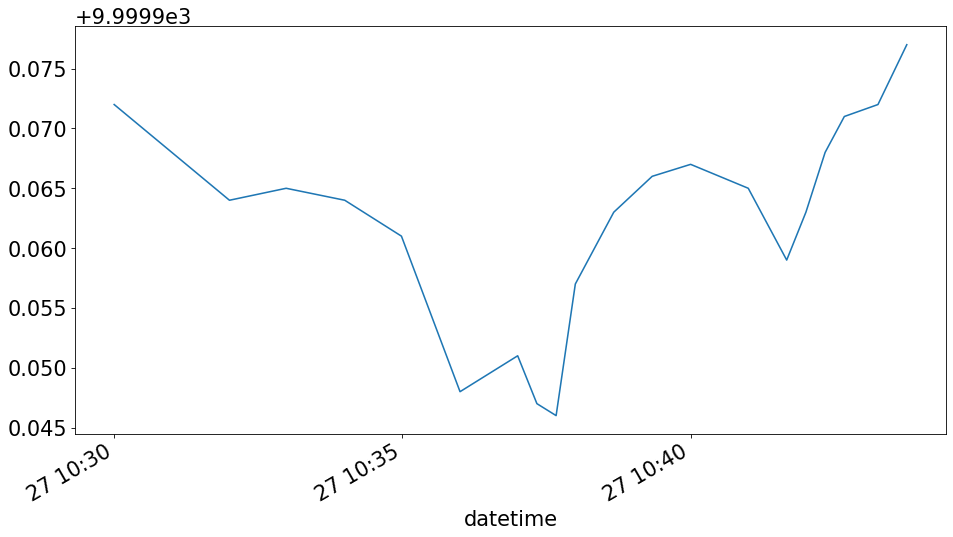

In [73]:
res_4w_data[res_4w_data.index < pd.Timestamp(2022,8,27,11)]['ag3458a_branadic_ohm'].plot()

In [74]:
(1-(ag3458a_dc_cal_data_fixed_units[(ag3458a_dc_cal_data_fixed_units.function == 'dcv') & (ag3458a_dc_cal_data_fixed_units.range == 10) & (ag3458a_dc_cal_data_fixed_units.input == 10)].correction.values[0])) * 1e6

5.399976240161308

In [75]:
ag3458a_dc_cal_data_fixed_units

,function,range,input,correction,uncertainty
0,dcv,1.0000000e-01,1.0000000e-01,9.9999420e-01,3.7000000e-07
1,dcv,1.0000000e-01,-1.0000000e-01,9.9999550e-01,4.3000000e-07
2,dcv,1.0000000e+00,1.0000000e+00,9.9999450e-01,1.8000000e-06
3,dcv,1.0000000e+00,-1.0000000e+00,9.9999400e-01,1.8000000e-06
4,dcv,1.0000000e+01,1.0000000e+01,9.9999460e-01,1.5000000e-05
5,dcv,1.0000000e+01,-1.0000000e+01,9.9999440e-01,1.5000000e-05
6,dcv,1.0000000e+02,1.0000000e+02,9.9999540e-01,1.8000000e-04
7,dcv,1.0000000e+02,-1.0000000e+02,9.9999600e-01,1.8000000e-04
8,dcv,1.0000000e+03,1.0000000e+03,1.0000052e+00,5.4000000e-03
9,dcv,1.0000000e+03,-1.0000000e+03,1.0000067e+00,5.4000000e-03


In [76]:
pd.set_option('display.float_format', lambda x: '%.7e' % x)
guard_comparison = dcv_data[(dcv_data.dut == 'Fluke 7001 on battery (alm)') & (dcv_data.dut_setting == '10 V') & (dcv_data.index > pd.Timestamp(2022,8,27,15))].groupby('comments').agg({'ag3458a_branadic_dcv': ['mean', 'std', 'count', 'sem']})
guard_comparison

ag3458a_branadic_dcv                                  
                                   mean           std count           sem
comments                                                                 
no guard, to lo           9.9999896e+00 8.3666003e-08     5 3.7416574e-08
with guard to lo          9.9999707e+00 1.5811388e-07     5 7.0710678e-08
with guard to open        9.9999900e+00 1.1401754e-07     5 5.0990195e-08

<ErrorbarContainer object of 3 artists>

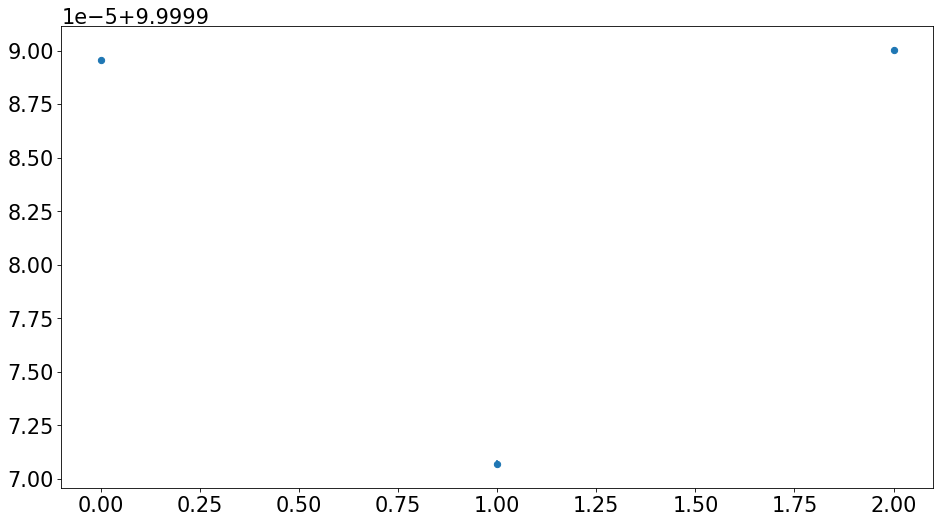

In [77]:
plt.errorbar(range(3), guard_comparison['ag3458a_branadic_dcv']['mean'], yerr=guard_comparison['ag3458a_branadic_dcv']['std'], fmt='o')

In [78]:
9.9999896 - 9.9999900

-4.000000011217253e-07